In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score 

In [7]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

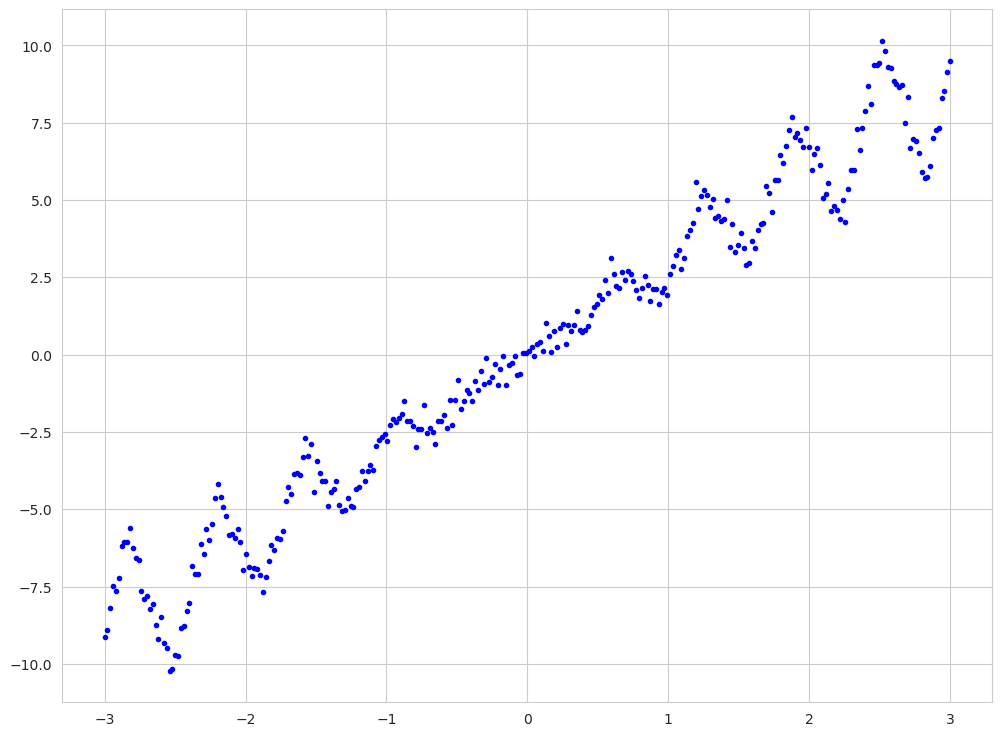

In [8]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [9]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=90)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

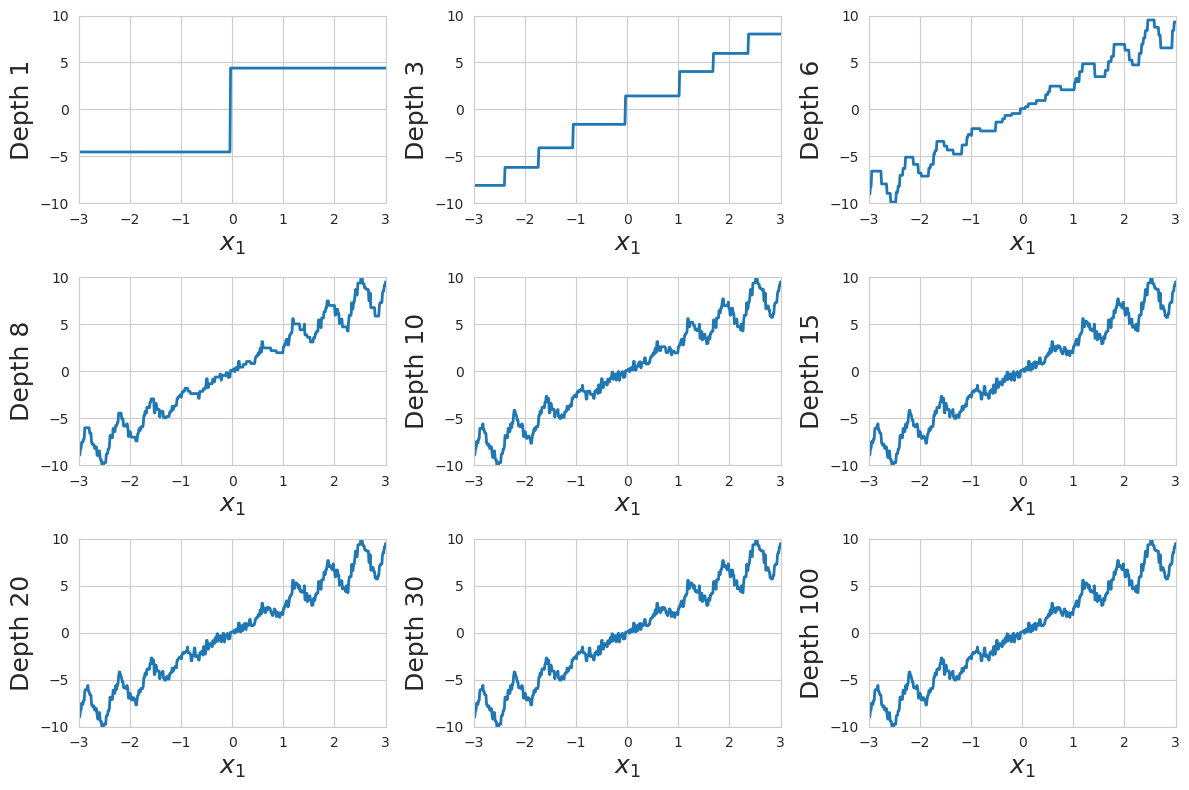

In [10]:
# предсказания для разных глубин дерева:
depths = [1, 3, 6, 8, 10, 15, 20, 30, 100]  

plt.figure(figsize=(12, 8))
for depth in depths:
    tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree_reg.fit(X, y)
    plt.subplot(3, 3, depths.index(depth) + 1)
    plot_regression_predictions(tree_reg, X, y, ylabel="Depth %d" % depth)

plt.tight_layout()
plt.show()

> На данных графиках начиная с `depth = 8` модель довольно точно описывает исходные данные - то есть bias снижается, variance не растет. Однако модели с большим значением глубины будут дольше считаться и переобучаться, поэтому оптимальным значением я бы выбрала `depth = 10`

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

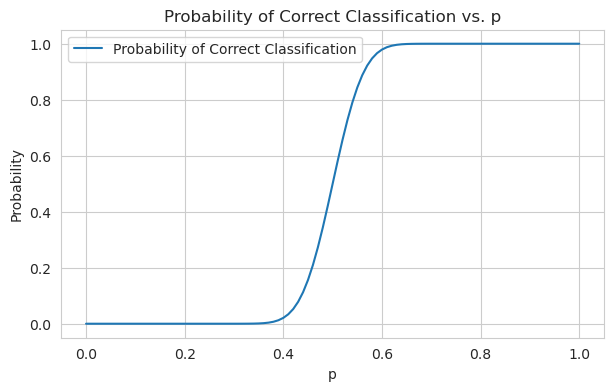

In [11]:
# Функция для вычисления вероятности правильной классификации объекта
def probability_correct_classification(p):
    mu = 0
    for i in range(51, 102):
        mu += np.math.comb(101, i) * p**i * (1-p)**(101-i)
    return mu

# Значения p от 0 до 1 с шагом 0.01
p_values = np.linspace(0, 1, 101)
probabilities = [probability_correct_classification(p) for p in p_values]

# Построение графика
plt.figure(figsize=(7, 4))
plt.plot(p_values, probabilities, label="Probability of Correct Classification")
plt.xlabel("p")
plt.ylabel("Probability")
plt.title("Probability of Correct Classification vs. p")
plt.legend()
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

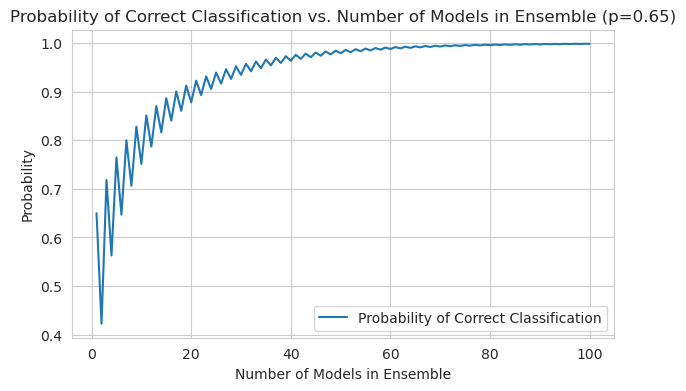

In [12]:
# Функция для вычисления вероятности правильной классификации объекта для ансамбля из n моделей
def probability_correct_classification_ensemble(n, p):
    mu = 0
    for k in range(n//2 + 1, n+1):
        mu += np.math.comb(n, k) * p**k * (1-p)**(n-k)
    return mu

# Значения числа моделей в ансамбле от 1 до 100
n_values = np.arange(1, 101)
p = 0.65
probabilities = [probability_correct_classification_ensemble(n, p) for n in n_values]

# Построение графика
plt.figure(figsize=(7, 4))
plt.plot(n_values, probabilities, label="Probability of Correct Classification")
plt.xlabel("Number of Models in Ensemble")
plt.ylabel("Probability")
plt.title("Probability of Correct Classification vs. Number of Models in Ensemble (p=0.65)")
plt.legend()
plt.show()

Опишите ваши наблюдения:

* При данных условиях (вероятность предсказания `p` для всех моделей в ансамбле равна, предсказание большинством голосов) ансамбль будет предсказывать значения со 100% точностью (ну или почти) при `p >= 0.6`
  
* При числе моделей в ансамбле $n \approx 70$ график вероятности точно предсказать значение выходит на плато, где вероятность точного предсказания составляет 100%

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [13]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        for i in range(self.n_estimators - 1):
            np.random.seed(self.random_state + i)
            feat_ids = np.random.choice(range(X.shape[1]), self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids)
            
            sample_indices = np.random.choice(range(X.shape[0]), X.shape[0], replace=True)
            X_sampled = X[sample_indices][:, feat_ids].reshape(-1, 1)
            y_sampled = y[sample_indices].reshape(-1, 1)
            
            tree = DecisionTreeClassifier(max_depth=self.max_depth, 
                                          max_features=self.max_features, 
                                          random_state=self.random_state)
            tree.fit(X_sampled, y_sampled)
            self.trees.append(tree)
            
        return self

    def predict_proba(self, X):
        probas = np.zeros((X.shape[0], len(self.classes_)))
        
        for i, tree in enumerate(self.trees):
            feat_ids = self.feat_ids_by_tree[i]
            X_subset = X[:, feat_ids].reshape(-1, 1)
            tree_probas = tree.predict_proba(X_subset)
            probas += tree_probas
        
        probas /= len(self.trees)
        
        return probas
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [14]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

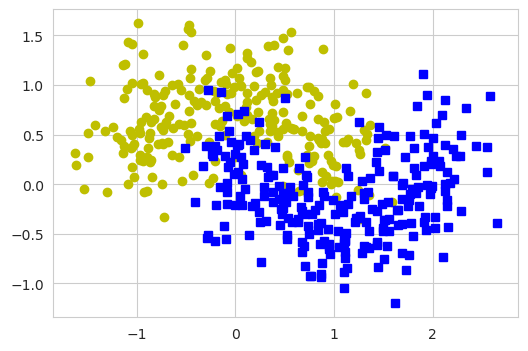

In [15]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(6, 4))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

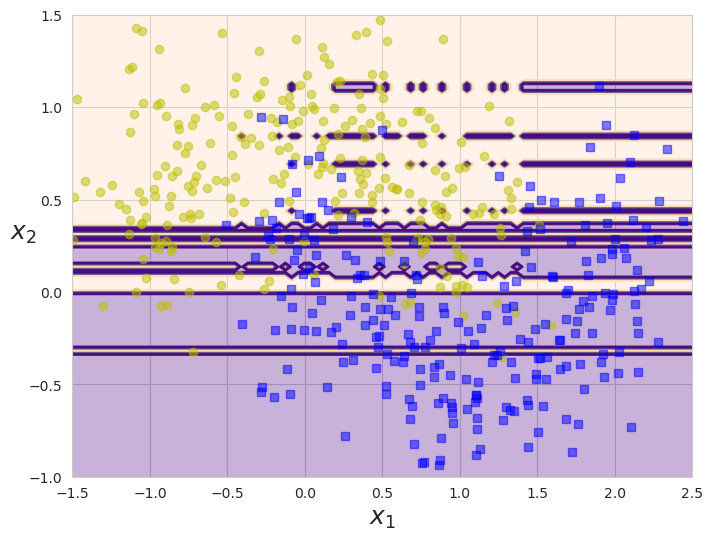

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

plt.figure(figsize=(8, 6))
custom_rf_clf = RandomForestClassifierCustom()
custom_rf_clf.fit(X_train, y_train)
plot_decision_boundary(custom_rf_clf, X, y)
plt.show()

In [17]:
y_pred = custom_rf_clf.predict(X_test)
ac = accuracy_score(y_test, y_pred)
ac

0.75

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [5, 10, 20, 50, 100, 500, 1000],
    'max_depth': [1, 5, 10, 20, 50, 100]
}

grid_search = GridSearchCV(custom_rf_clf, param_grid, scoring='accuracy', refit='accuracy', n_jobs=8)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print(f"Best accuracy: {grid_search.best_score_:,.3f}")

# Получение лучшей модели
best_ensemble = grid_search.best_estimator_


Best params: {'max_depth': 5, 'n_estimators': 1000}
Best accuracy: 0.872


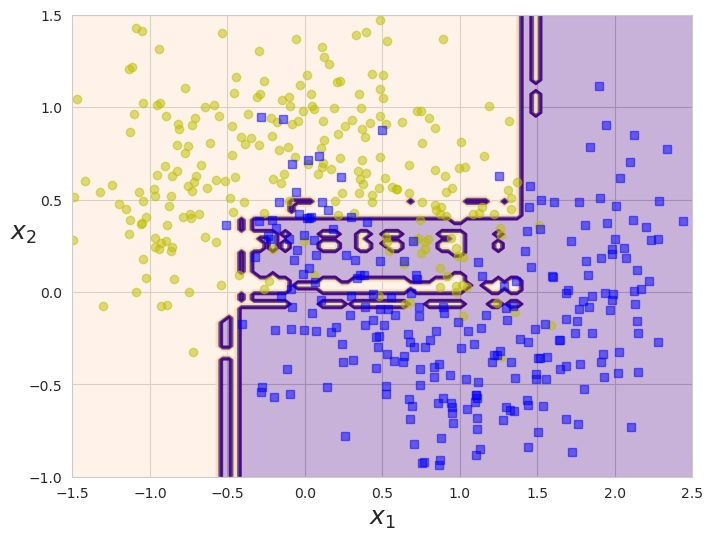

In [19]:
# График для модели с лучшими параметрами:
plt.figure(figsize=(8, 6))
best_ensemble.fit(X_train, y_train)
plot_decision_boundary(best_ensemble, X, y)
plt.show()

> Есть опасения, что в `RandomForestClassifierCustom.fit` я что-то не то сделала, не могу понять что. И либо данные такие, либо я не понимаю как работать с параметром `max_features`, при любых значениях кроме 1 код падает с ошибкой
>
> Ну а сама модель, судя по графику выше, выглядит вроде более менее норм. Я бы сказала, bias великоват, тк по центру захватывает область желтых точек и не угадывает синие точки чуть выше. Variance тоже стоило бы чуть пофиксить и уменьшить, но как не понимаю((

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [20]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [21]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [22]:
breast_cancer.feature_names.size

30

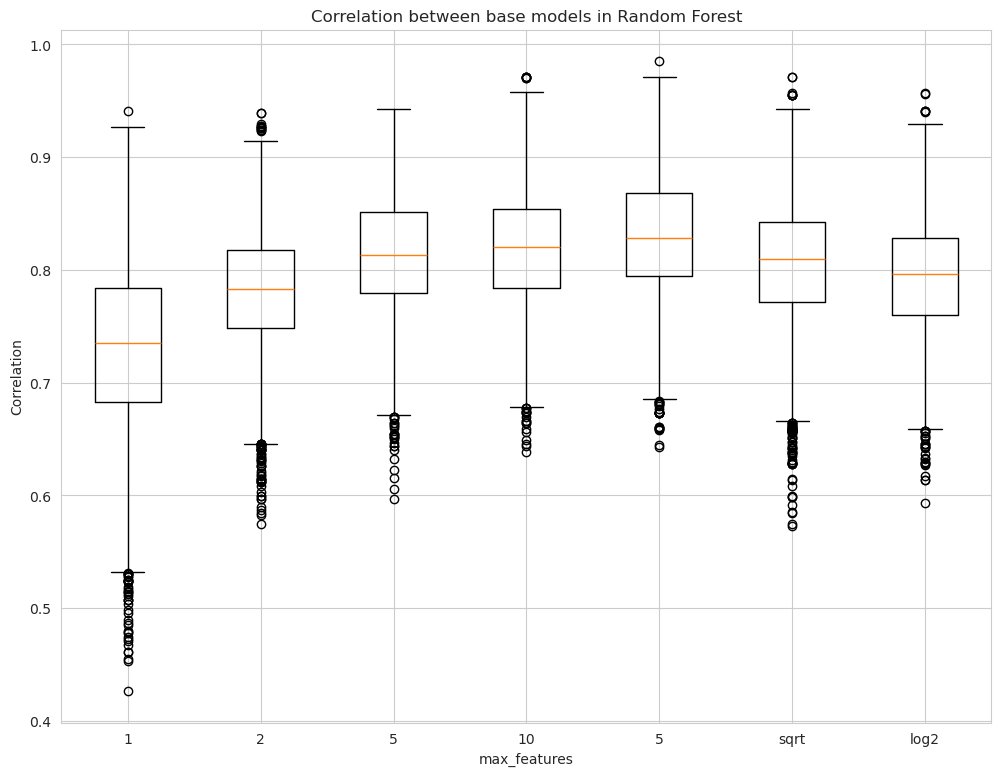

In [23]:
# Различные значения max_features для случайного леса:
max_features_values = [1, 2, 5, 10, None, 'sqrt', 'log2']

# Изобразим корреляции в виде боксплотов:
correlation_results = []
for max_features in max_features_values:
    rf = RandomForestClassifier(n_estimators=100, max_features=max_features)
    rf.fit(X_train, y_train)
    correlations = base_model_pair_correlation(rf, X_test)
    correlation_results.append(correlations)

plt.boxplot(correlation_results, labels=max_features_values)
plt.xlabel('max_features')
plt.ylabel('Correlation')
plt.title('Correlation between base models in Random Forest')
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

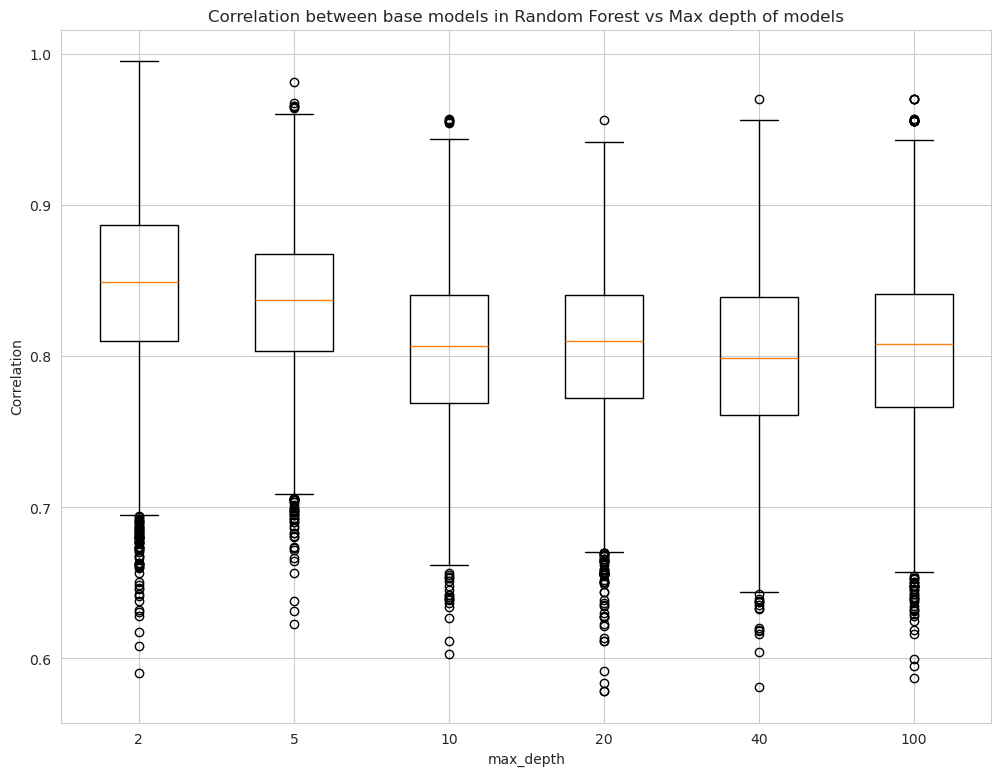

In [24]:
# Зафиксируем max_features = sqrt, чтоб по-христиански было
# ибо пишут, что принято для классификации брать sqrt(all_features) 

max_depth_values = [2, 5, 10, 20, 40, 100]

correlation_results = []
for max_depth in max_depth_values:
    rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=max_depth)
    rf.fit(X_train, y_train)
    correlations = base_model_pair_correlation(rf, X_test)
    correlation_results.append(correlations)

plt.boxplot(correlation_results, labels=max_depth_values)
plt.xlabel('max_depth')
plt.ylabel('Correlation')
plt.title('Correlation between base models in Random Forest vs Max depth of models')
plt.show()


Опишите ваши наблюдения:

* Чем меньше признаков в моделях, тем меньше корреляция между ними (что логично - чем меньше признаком, тем более модели непохожи между собой)
* Глубина дерева на корреляции влияет слабее, особой разницы нет как будто бы. Можно увидеть тренд снижения аутокорреляции при увеличении глубины дерева.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [26]:
# !gdown 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../raw_data/heart.csv")

In [27]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
178   43    1   0       120   177    0        0      120      1      2.5   
298   57    0   0       140   241    0        1      123      1      0.2   
201   60    1   0       125   258    0        0      141      1      2.8   
246   56    0   0       134   409    0        0      150      1      1.9   
153   66    0   2       146   278    0        0      152      0      0.0   

     slope  ca  thal  
178      1   0     3  
298      1   0     3  
201      1   1     3  
246      1   2     3  
153      1   1     2

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [28]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [29]:
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

models = []
all_scores = []
for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    models.append(f"{model.__class__.__name__}") 
    all_scores.append(scores.mean())

[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [30]:
df_summary = pd.DataFrame({'Model': models, 'F1 score': all_scores})
df_summary.sort_values(by='F1 score', ascending = False)

Model  F1 score
11      LogisticRegression  0.850007
9          XGBRFClassifier  0.849948
13        VotingClassifier  0.849444
14        VotingClassifier  0.845511
5                      SVC  0.840310
2       CatBoostClassifier  0.834272
1   RandomForestClassifier  0.832875
3     ExtraTreesClassifier  0.828175
8           LGBMClassifier  0.817011
12              GaussianNB  0.814068
7            XGBClassifier  0.813452
10          LGBMClassifier  0.813248
0   DecisionTreeClassifier  0.797997
6                      SVC  0.697312
4     KNeighborsClassifier  0.649331

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [31]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [32]:
voting_hard.fit(X_train, y_train)
correlations = base_model_pair_correlation_for_voting_clf(voting_hard, X_test)

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [33]:
df = pd.DataFrame(columns = ['Model1', 'Model2', 'Pearson corr score'])
for record in correlations: # model1, model2, correlation
    df.loc[len(df)] = list(record)
df.sort_values(by='Pearson corr score', ascending=False)

Model1  \
64                   LGBMClassifier(random_state=111)   
57  <catboost.core.CatBoostClassifier object at 0x...   
26  (ExtraTreeClassifier(random_state=481767252), ...   
48  SVC(kernel='linear', probability=True, random_...   
60  <catboost.core.CatBoostClassifier object at 0x...   
..                                                ...   
40           KNeighborsClassifier(weights='distance')   
33           KNeighborsClassifier(weights='distance')   
51            SVC(probability=True, random_state=111)   
41           KNeighborsClassifier(weights='distance')   
53            SVC(probability=True, random_state=111)   

                                               Model2  Pearson corr score  
64  XGBClassifier(base_score=None, booster=None, c...            0.970839  
57                   LGBMClassifier(random_state=111)            0.955278  
26  <catboost.core.CatBoostClassifier object at 0x...            0.952720  
48  LogisticRegression(max_iter=10000, solver='lib...            0.952159  
60  XGBRFClassifier(base_score=None, booster=None,...            0.945480  
..                                                ...                 ...  
40  LogisticRegression(max_iter=10000, solver='lib...            0.269734  
33  SVC(kernel='linear', probability=True, random_...            0.249790  
51                   LGBMClassifier(random_state=111)            0.234962  
41                                       GaussianNB()            0.231372  
53  XGBClassifier(base_score=None, booster=None, c...            0.226339  

[78 rows x 3 columns]

#### ✨✨✨✨😃Начинаем магию перебора😃✨✨✨✨

***Гридсерчи не запускать, все параметры уже посчитанные данным кодом ниже!!!***

In [206]:
dt_param_grid = {'max_depth':[2, 5, 10, 15, 20, 50],
                 'min_samples_leaf':[5, 10, 20],
                 'min_samples_split': [2, 3, 5, 8, 15],
                 'max_features': [2, 5, 'sqrt', 'log2']}
dt_search = GridSearchCV(DecisionTreeClassifier(random_state=SEED), dt_param_grid, cv=5, scoring='f1')
dt = dt_search.fit(X_train, y_train).best_estimator_

In [211]:
rf_param_grid = {'n_estimators': [10, 50, 100],
                 'max_depth':[2, 5, 10, 15, 20],
                 'min_samples_leaf':[5, 10, 20],
                 'min_samples_split': [2, 3, 5, 8, 15],
                 'max_features': [2, 5, 'sqrt', 'log2'],
                 'max_samples': [100, 300, 500]}  

rf_search = GridSearchCV(RandomForestClassifier(random_state=SEED, bootstrap=True, n_jobs=8), 
                             rf_param_grid, cv=5, scoring='f1', n_jobs=8)
rf = rf_search.fit(X_train, y_train).best_estimator_

In [212]:
etc_param_grid = {'n_estimators': [50, 100, 200],
                  'max_depth':[2, 5, 10, 15, 20, 50],
                  'min_samples_leaf':[5, 10, 20],
                  'min_samples_split': [2, 3, 5, 8, 15],
                  'max_features': [2, 5, 'sqrt', 'log2'],
                  'max_samples': [100, 300, 500]}
etc_search = GridSearchCV(ExtraTreesClassifier(random_state=SEED, bootstrap=True, n_jobs=8), 
                          etc_param_grid, cv=5, scoring='f1', n_jobs=8)
etc = etc_search.fit(X_train, y_train).best_estimator_

In [214]:
knn_param_grid = {'n_neighbors': [3, 5, 8, 12, 20],
                 'metric': ['manhattan', 'euclidean', 'cosine']}
knn_search = GridSearchCV(KNeighborsClassifier(weights='distance'), knn_param_grid, cv=5, scoring='f1')
knn = knn_search.fit(X_train, y_train).best_estimator_

In [34]:
# Best estimators are:

dt = DecisionTreeClassifier(max_depth=5, max_features=2, min_samples_leaf=10,
                       random_state=111)
rf = RandomForestClassifier(max_depth=2, max_samples=100, min_samples_leaf=5,
                       n_estimators=50, n_jobs=8, random_state=111)
etc = ExtraTreesClassifier(bootstrap=True, max_depth=5, max_features=2,
                     max_samples=100, min_samples_leaf=5, min_samples_split=15,
                     n_jobs=8, random_state=111)
knn = KNeighborsClassifier(metric='manhattan', weights='distance')

In [35]:
# models w/o GridSearch optimization:
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)                         
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("RF", rf),  ("CAT", cat), ("DT", dt),
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("LR", lr), ("NB", nb), ("LGBM", lgbm), ("XGB_RF", xgb_rf),  ("ETC", etc), ("KNN", knn)]

In [253]:
import copy

best_f1_score = 0
best_voting_ensemble = None

remaining_models = copy.deepcopy(base_models)
selected_models = []  # Список выбранных моделей


while remaining_models:
    best_f1_score_local = 0
    best_model = None
    
    for model in remaining_models:
        ensemble = selected_models + [model]
        voting_hard = VotingClassifier(estimators=ensemble, voting='hard')
        f1_scores = cross_val_score(voting_hard, X_train, y_train, cv=5, scoring='f1')
        avg_f1_score = np.mean(f1_scores)
        
        if avg_f1_score > best_f1_score_local:
            best_f1_score_local = avg_f1_score
            best_model = model
    
    if best_f1_score_local > best_f1_score:
        best_f1_score = best_f1_score_local
        best_voting_ensemble = selected_models + [best_model]
        
    selected_models.append(best_model)
    remaining_models.remove(best_model)
    

print("Best F1 Score:", best_f1_score)
print("Best Voting Ensemble:", best_voting_ensemble)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 94, number of negative: 87
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 181, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519337 -> initscore=0.077387
[LightGBM] [Info] Start training from score 0.077387
[Li

> Где-то на самом дне аутпута можно будет увидеть следующее:

In [ ]:
Best F1 Score: 0.8730298273155416
Best Voting Ensemble: [('LR', LogisticRegression(max_iter=10000, solver='liblinear')), 
                       ('SVC_LIN', SVC(kernel='linear', probability=True, random_state=111)), 
                       ('SVC_RBF', SVC(probability=True, random_state=111)), 
                       ('RF', RandomForestClassifier(max_depth=2, max_samples=100, min_samples_leaf=5,
                       n_estimators=50, n_jobs=8, random_state=111)), 
                       ('DT', DecisionTreeClassifier(max_depth=5, max_features=2, min_samples_leaf=10,
                       random_state=111))]

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [36]:
pd.set_option('display.max_columns', None)
data = pd.read_csv("../raw_data/churn.csv")
data.head()

State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge  Eve Mins  Eve Calls  \
0             25     265.1        110       45.07     197.4         99   
1             26     161.6        123       27.47     195.5        103   
2              0     243.4        114       41.38     121.2        110   
3              0     299.4         71       50.90      61.9         88   
4              0     166.7        113       28.34     148.3        122   

   Eve Charge  Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  \
0       16.78       244.7           91         11.01       10.0           3   
1       16.62       254.4          103         11.45       13.7           3   
2       10.30       162.6          104          7.32       12.2           5   
3        5.26       196.9           89          8.86        6.6           7   
4       12.61       186.9          121          8.41       10.1           3   

   Intl Charge  CustServ Calls  Churn?  
0         2.70               1  False.  
1         3.70               1  False.  
2         3.29               0  False.  
3         1.78               2  False.  
4         2.73               3  False.

In [37]:
data.shape

(3333, 21)

In [38]:
data.describe()
# ничего подозрительного не вижу

Account Length    Area Code  VMail Message     Day Mins    Day Calls  \
count     3333.000000  3333.000000    3333.000000  3333.000000  3333.000000   
mean       101.064806   437.182418       8.099010   179.775098   100.435644   
std         39.822106    42.371290      13.688365    54.467389    20.069084   
min          1.000000   408.000000       0.000000     0.000000     0.000000   
25%         74.000000   408.000000       0.000000   143.700000    87.000000   
50%        101.000000   415.000000       0.000000   179.400000   101.000000   
75%        127.000000   510.000000      20.000000   216.400000   114.000000   
max        243.000000   510.000000      51.000000   350.800000   165.000000   

        Day Charge     Eve Mins    Eve Calls   Eve Charge   Night Mins  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean     30.562307   200.980348   100.114311    17.083540   200.872037   
std       9.259435    50.713844    19.922625     4.310668    50.573847   
min       0.000000     0.000000     0.000000     0.000000    23.200000   
25%      24.430000   166.600000    87.000000    14.160000   167.000000   
50%      30.500000   201.400000   100.000000    17.120000   201.200000   
75%      36.790000   235.300000   114.000000    20.000000   235.300000   
max      59.640000   363.700000   170.000000    30.910000   395.000000   

       Night Calls  Night Charge    Intl Mins   Intl Calls  Intl Charge  \
count  3333.000000   3333.000000  3333.000000  3333.000000  3333.000000   
mean    100.107711      9.039325    10.237294     4.479448     2.764581   
std      19.568609      2.275873     2.791840     2.461214     0.753773   
min      33.000000      1.040000     0.000000     0.000000     0.000000   
25%      87.000000      7.520000     8.500000     3.000000     2.300000   
50%     100.000000      9.050000    10.300000     4.000000     2.780000   
75%     113.000000     10.590000    12.100000     6.000000     3.270000   
max     175.000000     17.770000    20.000000    20.000000     5.400000   

       CustServ Calls  
count     3333.000000  
mean         1.562856  
std          1.315491  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          2.000000  
max          9.000000

In [39]:
data.info()
# вроде тоже все норм

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [40]:
data.drop(columns=['Phone'], inplace = True)

In [41]:
# категории в 0 и 1:
data["Int\'l Plan"][data["Int\'l Plan"] == 'yes'] = 1
data["Int\'l Plan"][data["Int\'l Plan"] == 'no'] = 0
data["VMail Plan"][data["VMail Plan"] == 'yes'] = 1
data["VMail Plan"][data["VMail Plan"] == 'no'] = 0
data["Churn?"][data["Churn?"] == "True."] = 1
data["Churn?"][data["Churn?"] == "False."] = 0

data[["Int\'l Plan", "VMail Plan", "Churn?"]] = data[["Int\'l Plan", "VMail Plan", "Churn?"]].astype('int64', copy=False)

	3333 rows, 20 columns/variables

	Numeric categorical variables (number of unique values is less or equal 6):
 ['Area Code', "Int'l Plan", 'VMail Plan', 'Churn?']
	Numeric variables: 
 ['Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls']
	Object type variables:
 ['State']

Statictics for categorical variables:


Area Code  Counts  Frequency
0        415    1655      0.497
1        510     840      0.252
2        408     838      0.251

Int'l Plan  Counts  Frequency
0           0    3010      0.903
1           1     323      0.097

VMail Plan  Counts  Frequency
0           0    2411      0.723
1           1     922      0.277

Churn?  Counts  Frequency
0       0    2850      0.855
1       1     483      0.145


Statictics for numeric variables:


Account Length  VMail Message  Day Mins  Day Calls  \
mean                   101.065          8.099   179.775    100.436   
std                     39.822         13.688    54.467     20.069   
min                      1.000          0.000     0.000      0.000   
25%                     74.000          0.000   143.700     87.000   
median                 101.000          0.000   179.400    101.000   
75%                    127.000         20.000   216.400    114.000   
max                    243.000         51.000   350.800    165.000   
outliers count          18.000          1.000    25.000     23.000   

                Day Charge  Eve Mins  Eve Calls  Eve Charge  Night Mins  \
mean                30.562   200.980    100.114      17.084     200.872   
std                  9.259    50.714     19.923       4.311      50.574   
min                  0.000     0.000      0.000       0.000      23.200   
25%                 24.430   166.600     87.000      14.160     167.000   
median              30.500   201.400    100.000      17.120     201.200   
75%                 36.790   235.300    114.000      20.000     235.300   
max                 59.640   363.700    170.000      30.910     395.000   
outliers count      25.000    24.000     20.000      24.000      30.000   

                Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
mean                100.108         9.039     10.237       4.479        2.765   
std                  19.569         2.276      2.792       2.461        0.754   
min                  33.000         1.040      0.000       0.000        0.000   
25%                  87.000         7.520      8.500       3.000        2.300   
median              100.000         9.050     10.300       4.000        2.780   
75%                 113.000        10.590     12.100       6.000        3.270   
max                 175.000        17.770     20.000      20.000        5.400   
outliers count       22.000        30.000     46.000      78.000       49.000   

                CustServ Calls  
mean                     1.563  
std                      1.315  
min                      0.000  
25%                      1.000  
median                   1.000  
75%                      2.000  
max                      9.000  
outliers count         267.000


Total 0 missing values in 3333 rows
Next columns contain missing values:
	
Count of duplicated rows: 0



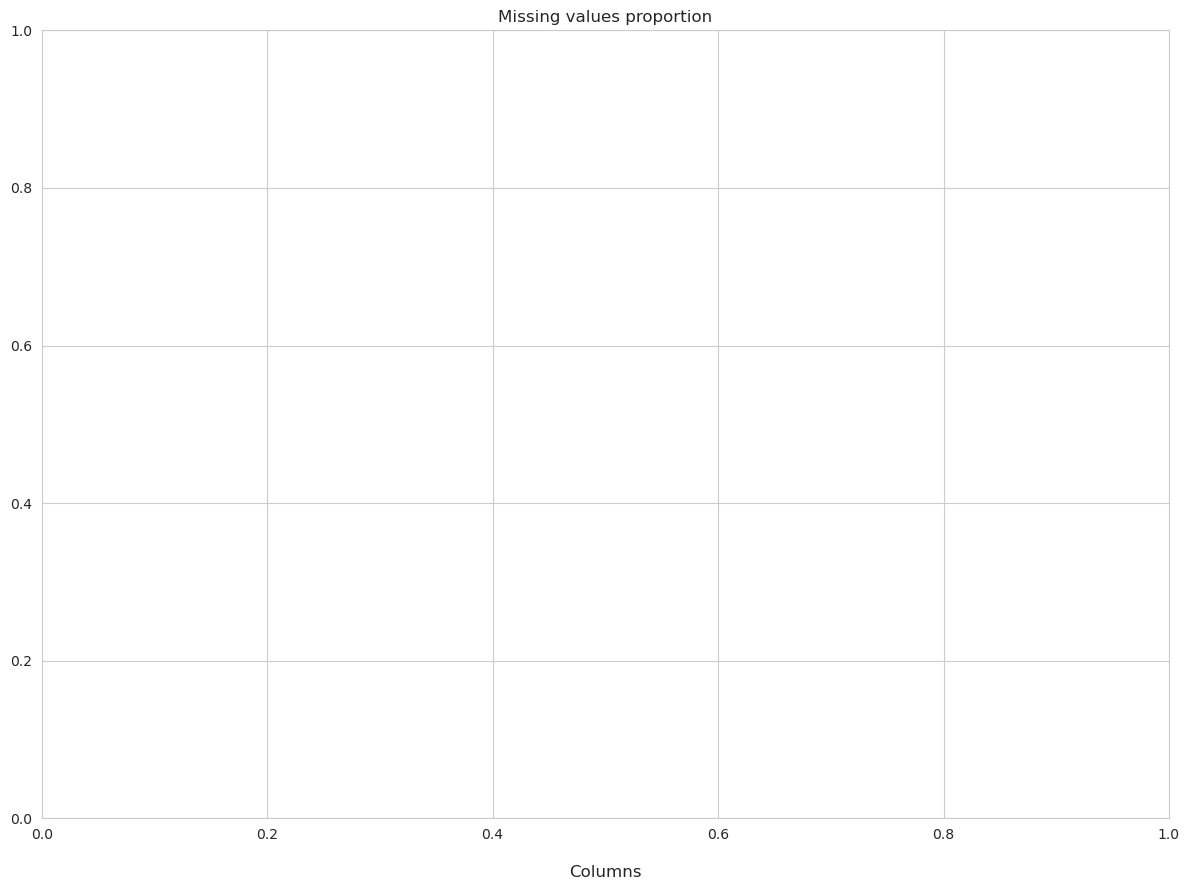

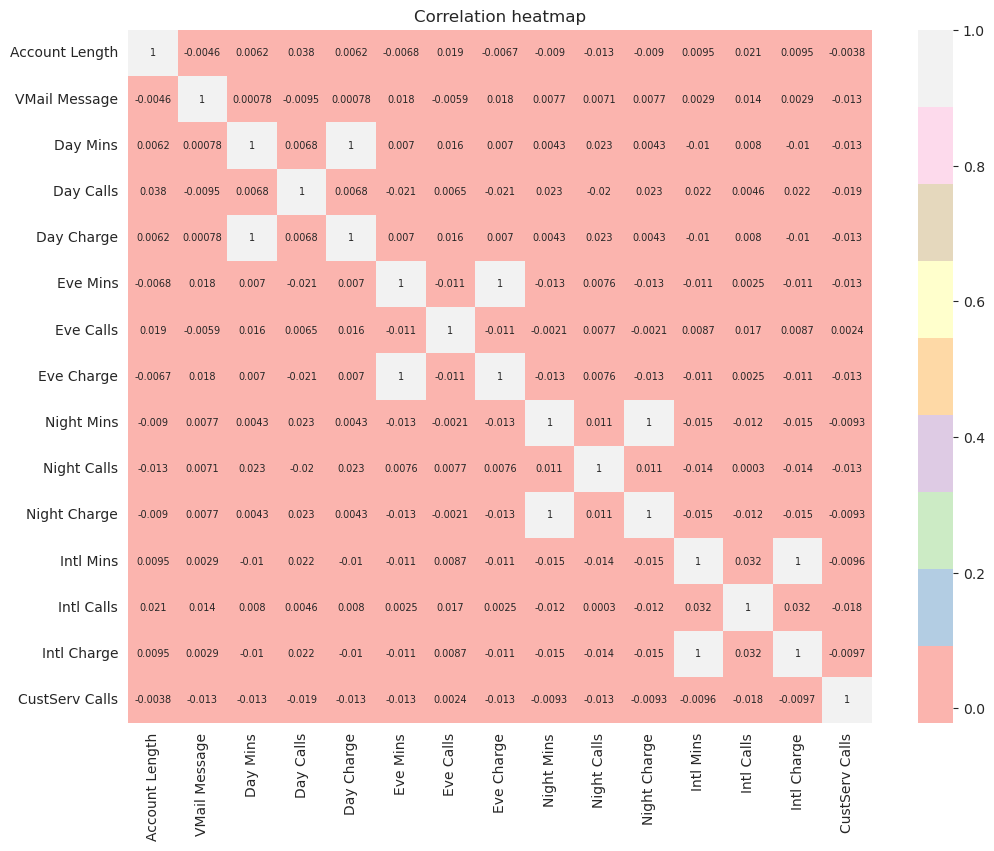

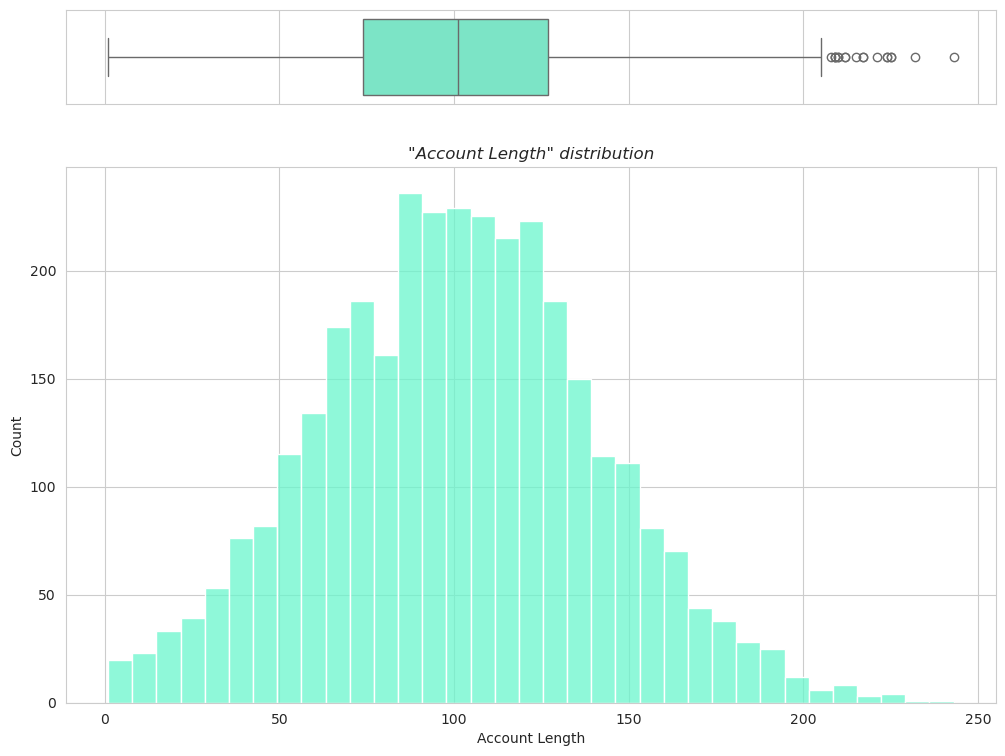

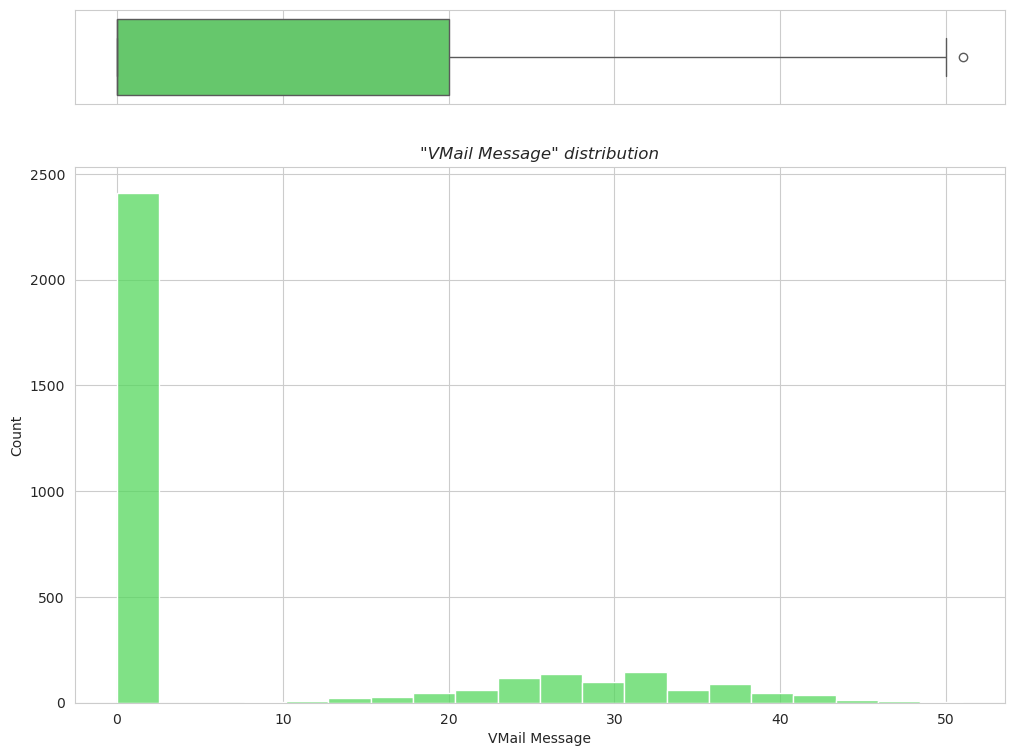

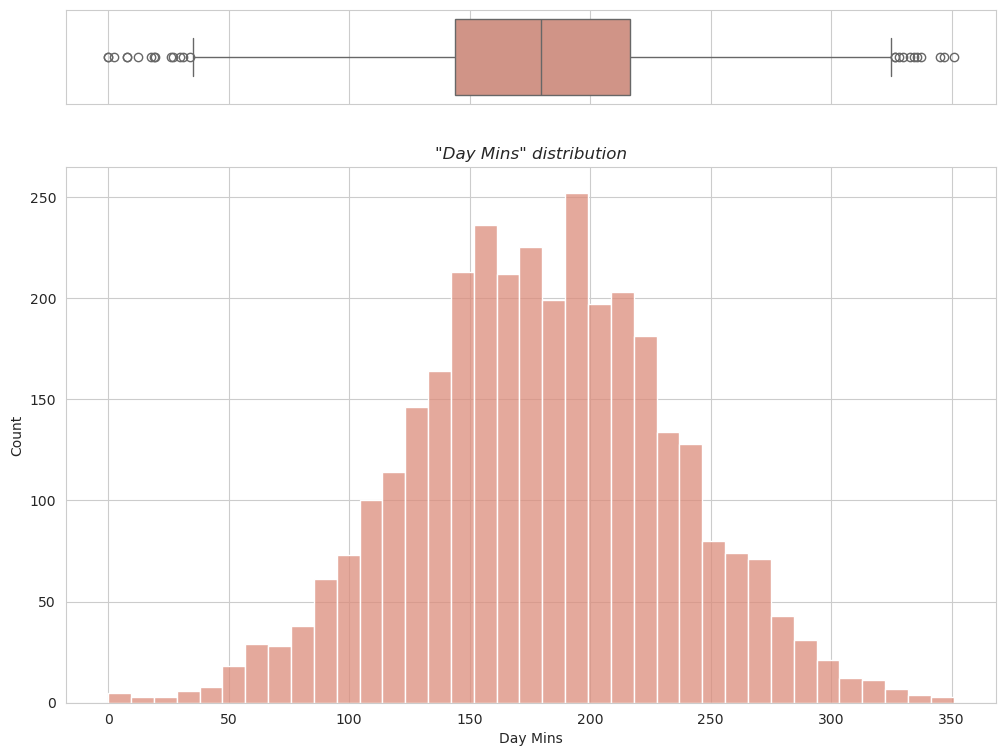

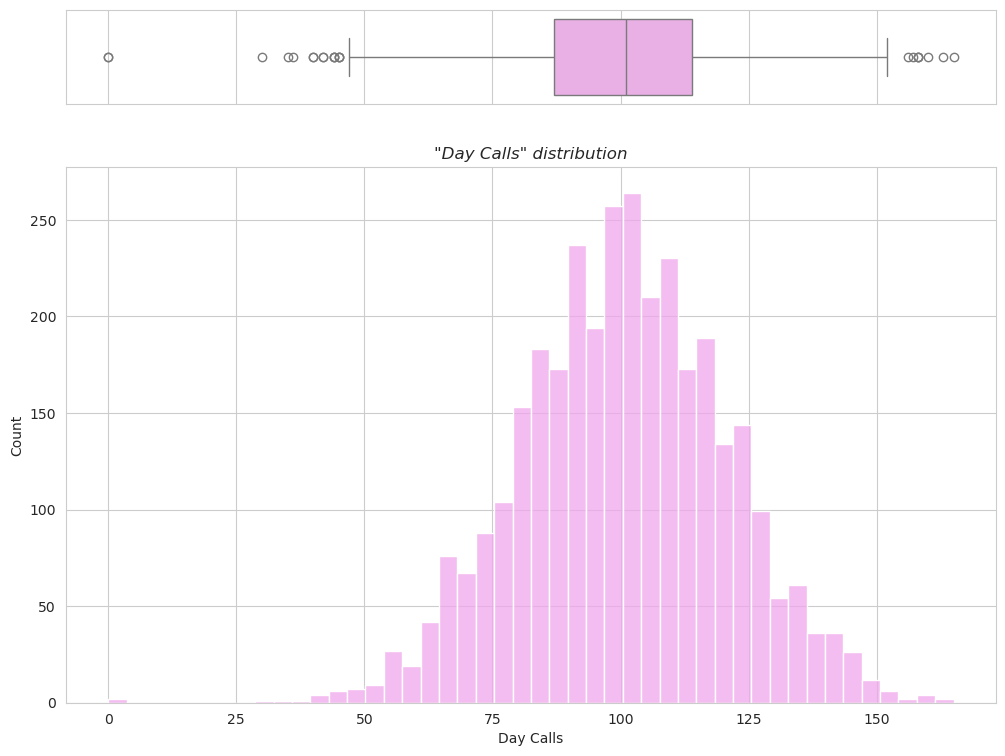

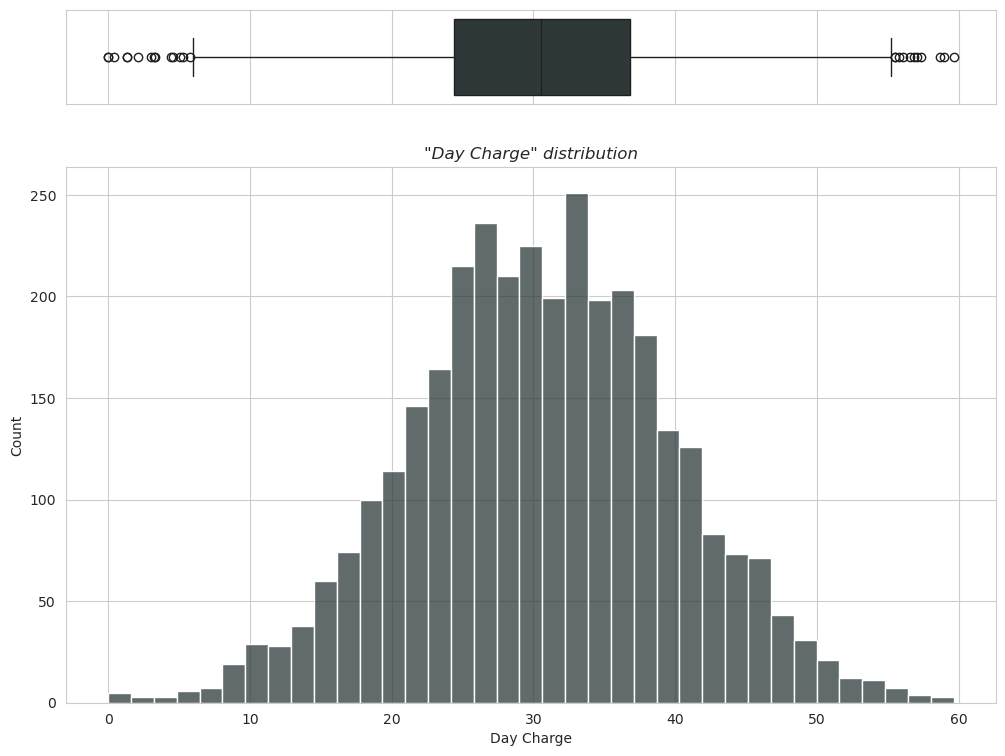

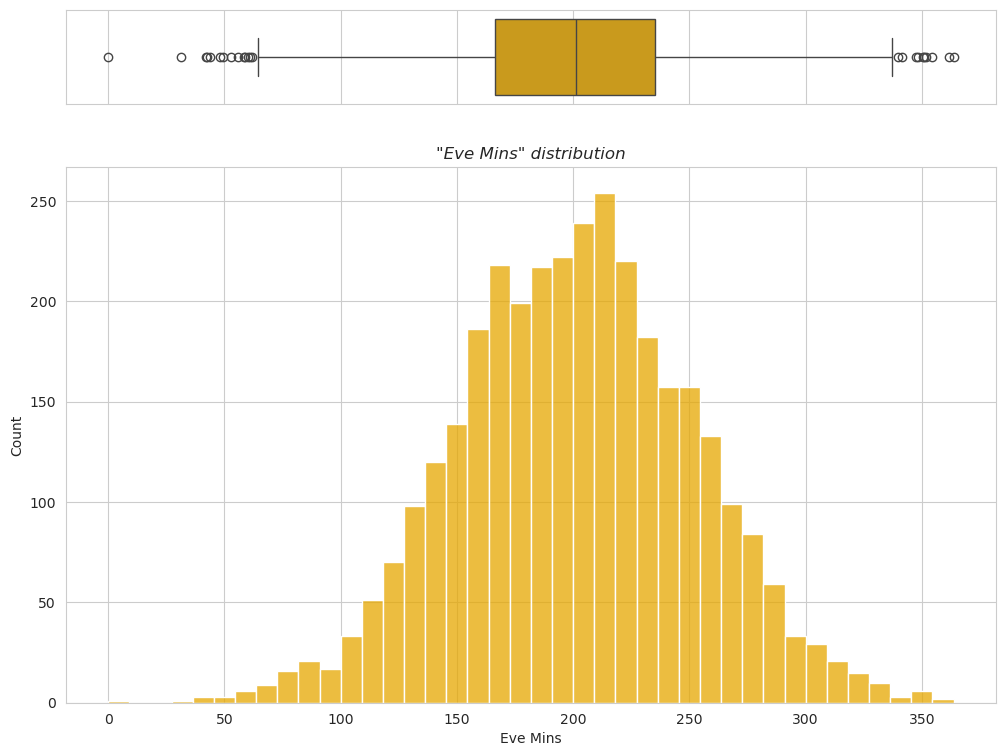

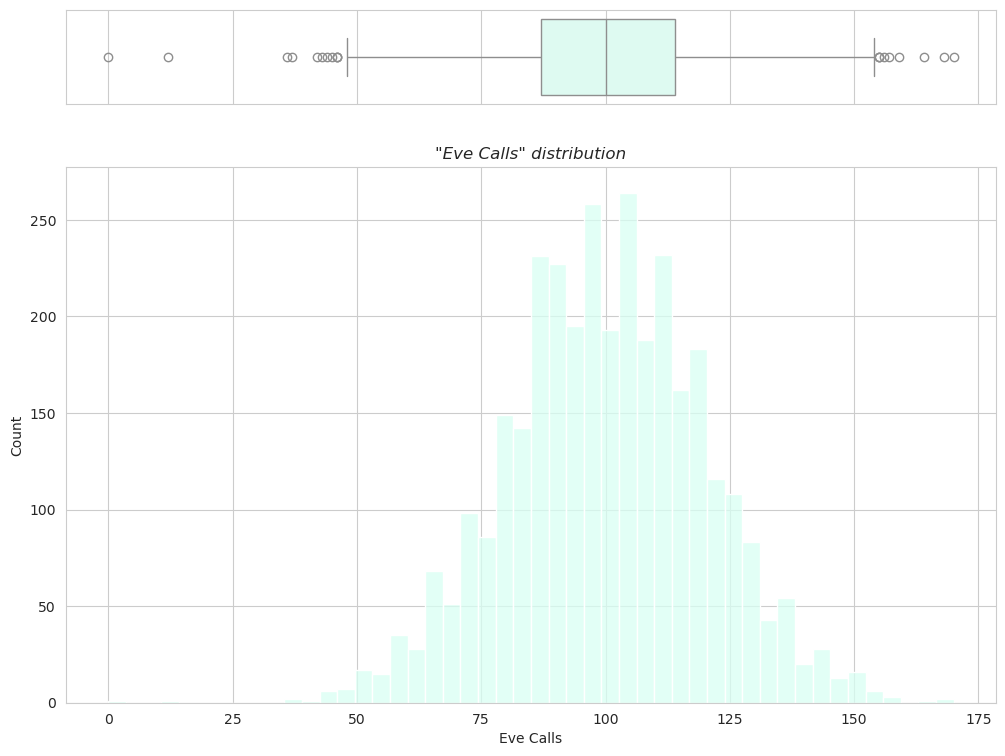

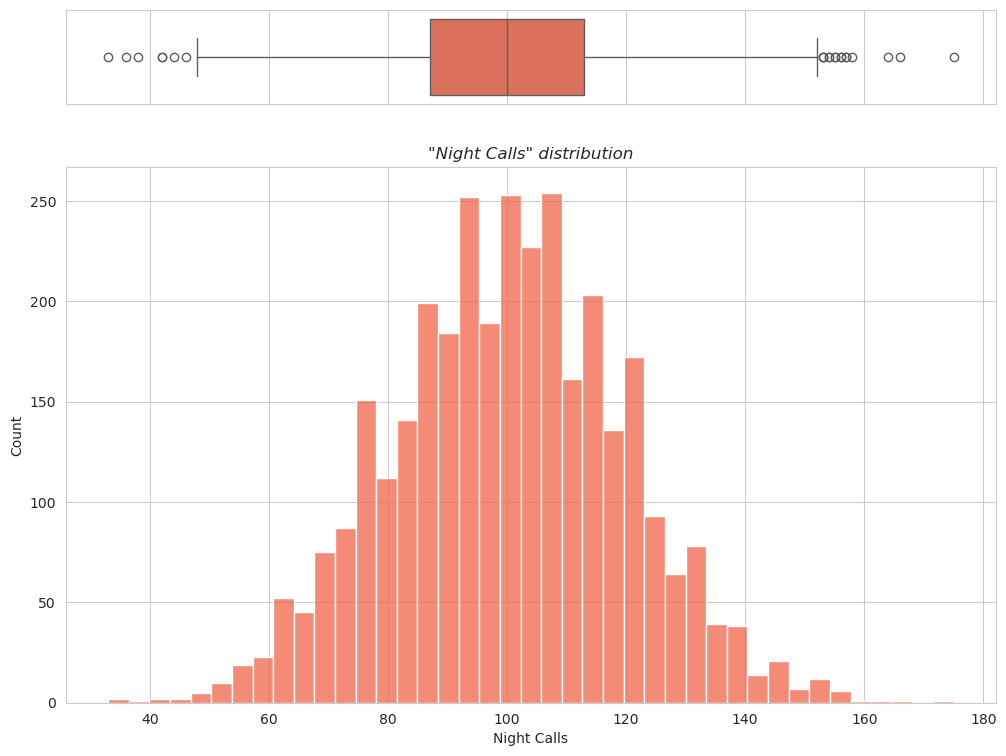

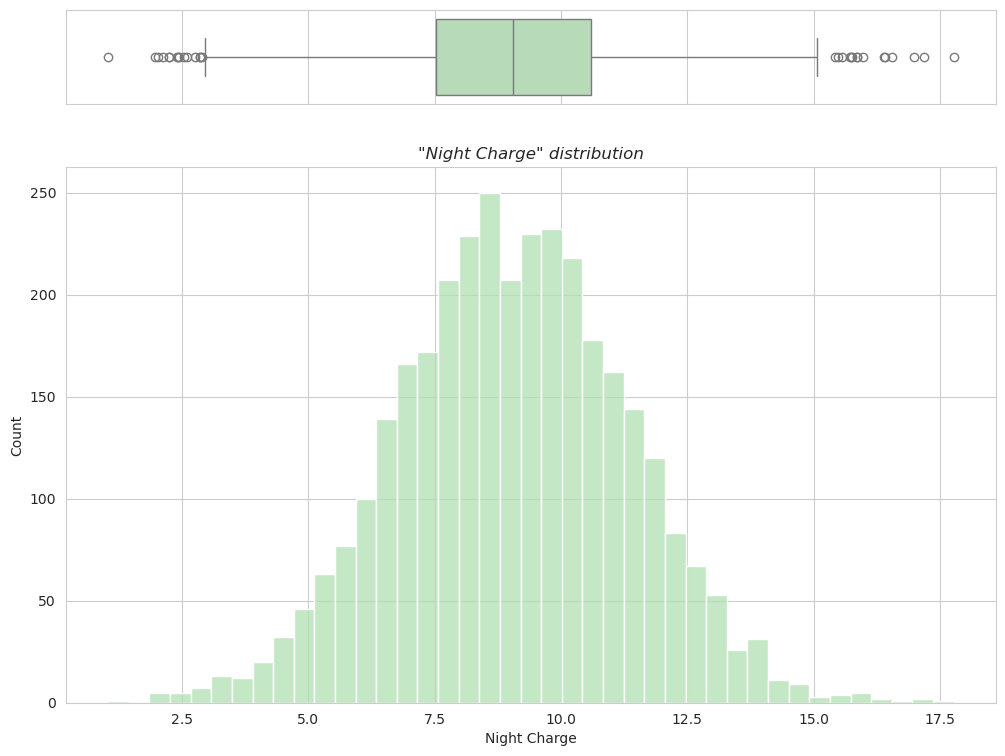

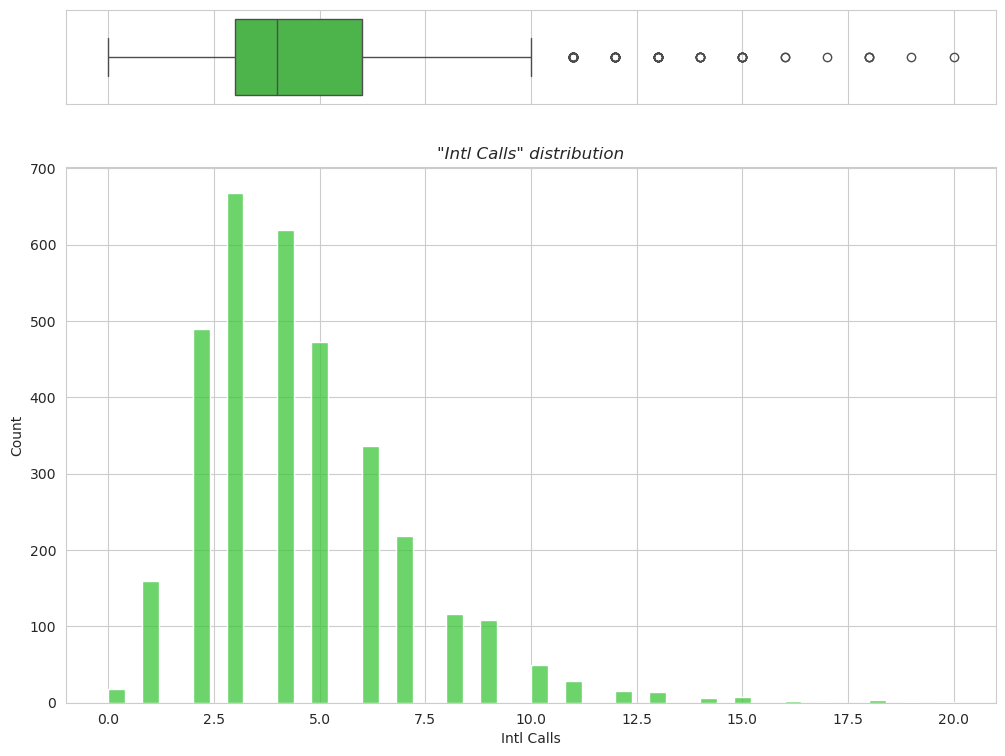

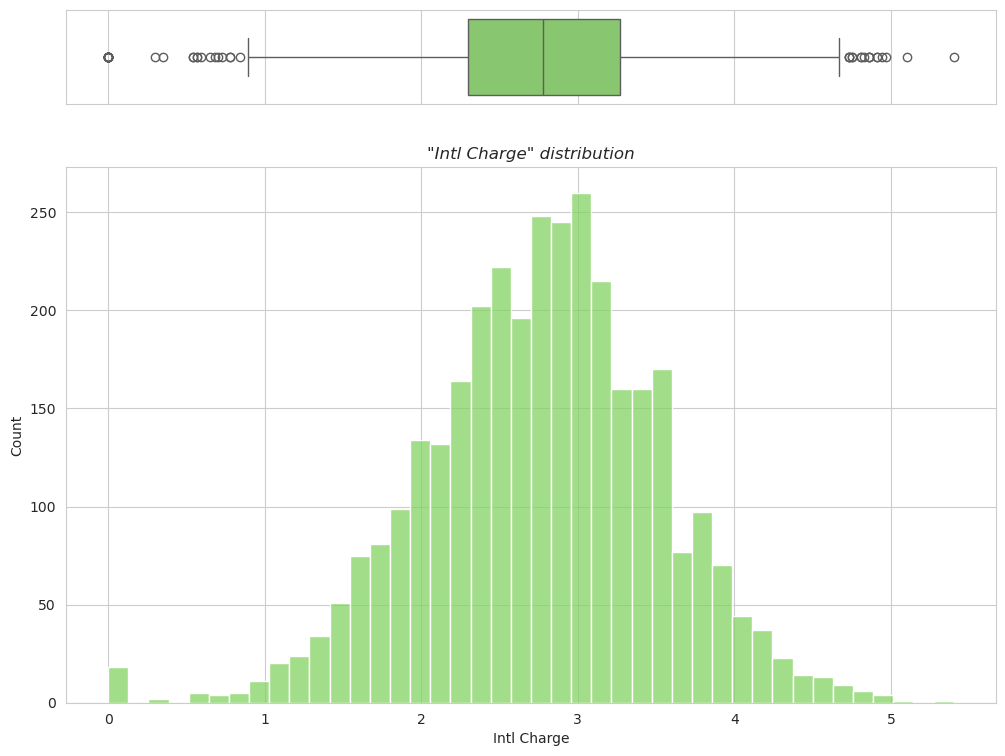

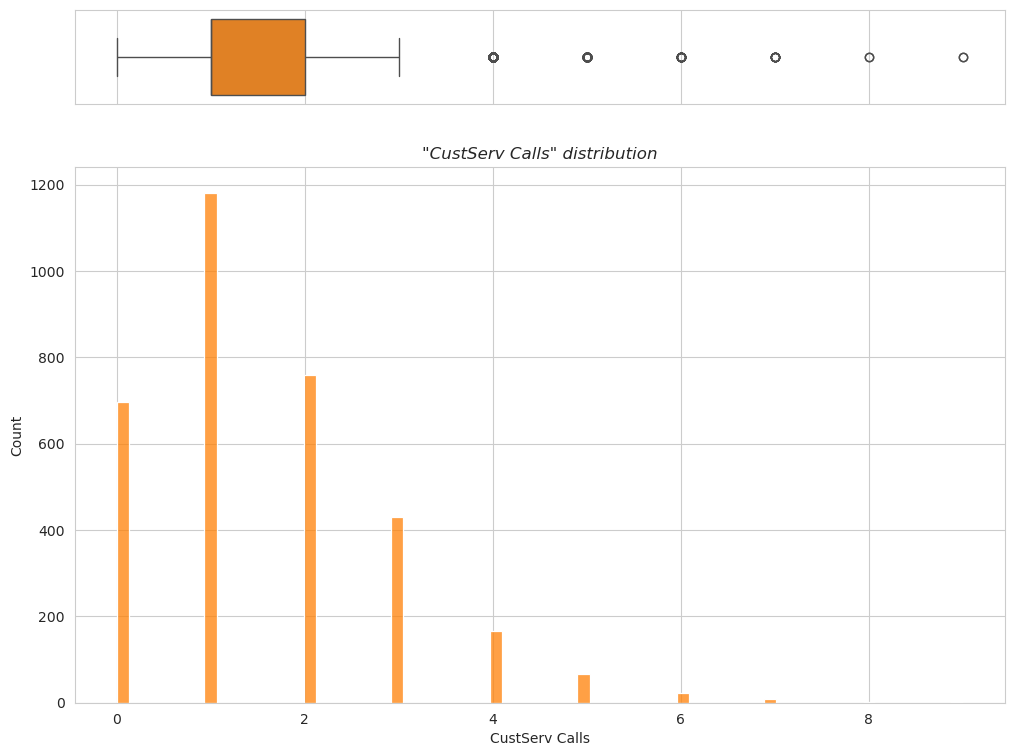

In [42]:
from my_awesome_eda import run_eda

run_eda(data)

> Распределены данные приемлемо, выбросы удалять смысла не вижу
>
> Для категориальных переменных выражен дисбаланс классов, особенно для `Int'l Plan` и таргетной переменной `Churn?`

In [43]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['State'] = le.fit_transform(data['State'])
# lightGBM ругается что тут строки

In [44]:
X = data[data.columns[:-1]]
y = data['Churn?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [271]:
# !pip install hyperopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.7 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.8 MB/s eta 0:00:00m eta 0:00:010:01:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 6.4 MB/s eta 0:00:000:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 5.4 MB/s eta 0:00:008.8 MB/s eta 0:00:01


In [39]:
# НЕ ЗАПУСКАТЬ ПЖ
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope


# Определение пространства поиска гиперпараметров 
space_lgbm = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 20, 50, 1)),
}

space_xgbrf = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
}

# Функция для оптимизации гиперпараметров с использованием байесовской оптимизации
def optimize(params, model):
    model.set_params(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    return -scores.mean()

# Подбор гиперпараметров
best_lgbm = fmin(fn=lambda params: optimize(params, lightgbm.LGBMClassifier()), space=space_lgbm, algo=tpe.suggest, max_evals=50, trials=Trials())
best_xgbrf = fmin(fn=lambda params: optimize(params, xgboost.XGBRFClassifier()), space=space_xgbrf, algo=tpe.suggest, max_evals=50, trials=Trials())



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines 
[LightGBM] [Info] Number of positive: 305, number of negative: 1827             
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2411                                               
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143058 -> initscore=-1.790119 
[LightGBM] [Info] Start training from score -1.790119                           
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines 
[LightGBM] [Info] Number of positive: 306, number of negative: 1827             
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002724 sec

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further sp

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No furt

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further sp

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further sp

In [41]:
# Best Hyperparameters for xgboostRF Classifier: 
best_xgbrf # {'learning_rate': 0.49253232099681904, 'max_depth': 9.0, 'n_estimators': 831.0}

{'learning_rate': 0.49253232099681904, 'max_depth': 9.0, 'n_estimators': 831.0}

In [40]:
# Best Hyperparameters for lightGBM Classifier: 
best_lgbm # {'learning_rate': 0.20060413492095586, 'max_depth': 8.0, 'n_estimators': 131.0, 'num_leaves': 39.0}

{'learning_rate': 0.20060413492095586,
 'max_depth': 8.0,
 'n_estimators': 131.0,
 'num_leaves': 39.0}

In [45]:
lgbm = lightgbm.LGBMClassifier(learning_rate=0.2, max_depth=8, n_estimators=131, num_leaves=39)
xgbrf = xgboost.XGBRFClassifier(learning_rate=0.5, max_depth=9, n_estimators=831)

for model in (lgbm, xgbrf):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score for {model.__class__.__name__}: {f1:.3f}')

# F1 score for LGBMClassifier: 0.811
# F1 score for XGBRFClassifier: 0.779

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 382, number of negative: 2284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2439
[LightGBM] [Info] Number of data points in the train set: 2666, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143286 -> initscore=-1.788263
[LightGBM] [Info] Start training from score -1.788263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

> Ну что ж... Честно говоря, прям понять и осознать не сильно много из этого получилось. Считалось оно пипяу сколько. Тем не менее, потыкаться в байесовскую оптимизацию было прикольно.
>
> Как и говорил Даня на лекции, lightGBM предсказывает более точно в случае имеющихся данных. Ну хотя и сами модели разные, да.
>

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

> Хочется нести в этот мир больше любви и позитива, поэтому вот вам розовое сердечко (тк больше я ничего рисовать не умею)
>
> 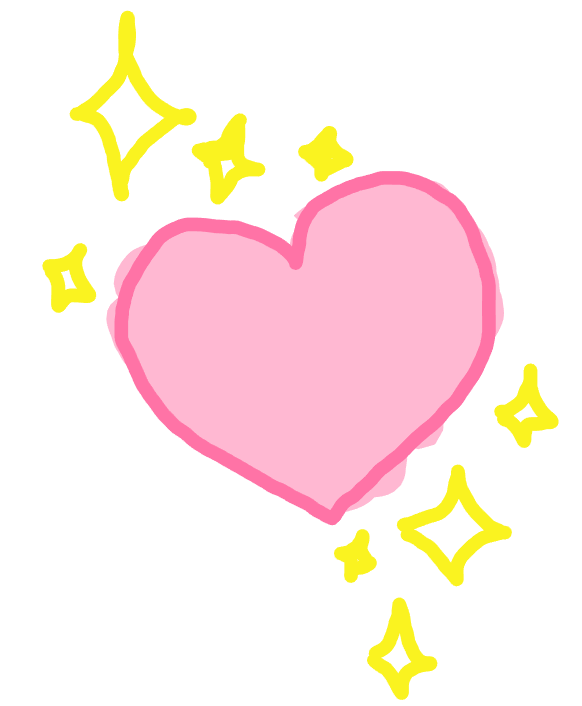

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

> Хз, как-то сложно. Вот вроде по ходу понимаю (ну, относительно) что делаю, а вот сейчас пишу этот текст и не то чтобы прям преисполнилась ансамблями и бустингом...(((
>
> Ну и еще не оч понятно как предобрабатывать данные в зависимости от алгоритма модели: деревья и лес вроде вообще не требовательны, и с NA норм работают, но ведь не все такие...